# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5
args.n_jobs = 3

args.X = args.raw_train.iloc[:, 1:].copy()
args.y = args.raw_train['label'].copy()
args.x = args.raw_test.copy()

args.run_cnn = False

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [2]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


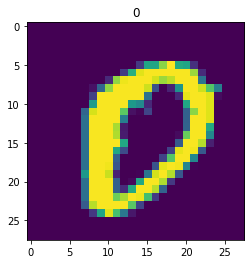

In [5]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
plt.title(title)
imgplot = plt.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

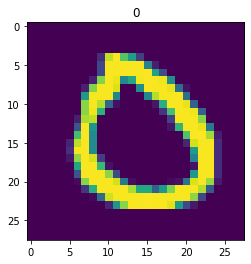

In [6]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
fig, ax = plt.subplots()
ax.set_title(title)
imgplot = ax.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

## 2. Training

In [7]:
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits, n_jobs=args.n_jobs):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=n_jobs, cv=skf, verbose=5)
    gcv.fit(X, y)
    print('Best params: ' + repr(gcv.best_params_))
    print('Best CV score: ' + repr(gcv.best_score_))
    print('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [8]:
def csv_predictions(predictions, filename):
    image_ids = np.arange(1, len(predictions) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    print('Saved file: ', filepath)

In [9]:
from keras import models
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [10]:
assert False

AssertionError: 

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def svm_classifier_builder(params_dict=None):
    _params_dict = params_dict if params_dict else {}
    return SVC(**_params_dict, kernel='linear')

parameters = {'C': [0.01], 'gamma': [0.001]}

if args.run_svm:
    best_params, score, predictions = predict(args.X, args.y, args.x, svm_classifier_builder, parameters)
    csv_predictions(predictions, 'svm_predictions.csv')

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Model  | Test score  |
|---|---|
| SVM  | 0.91900 |
| Random Forest  | 0.96814 |
| Extra Trees  | 0.97228 |
| XgBoost  | 0.96300 |
| MLP  | 0.97542 |